In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('./libs')

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import colorcet as cc
import numpy as np
import pandas as pd
import h5py
from ipywidgets import interact, widgets
import vismesh_funcs as atsvis
import ats_xdmf as ats_xdmf
import pyvista as pv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Visualize exodus2 mesh

In [4]:
domain_mesh = atsvis.load_mesh_exodus('../data/synthetic_catchment.exo', z_scale=20)
atsvis.plot_mesh(domain_mesh, show_scalar_bar=True, set_background=False,
                 show_toplayer=True, window_size=[800, 400])

Widget(value='<iframe src="http://localhost:49158/index.html?ui=P_0x30addde50_1&reconnect=auto" class="pyvista…

### Load ATS output files

In [5]:
# Load mesh polygons and data
data_directory = '../1-hydrology/results/'
domain = h5py.File(f'{data_directory}/ats_vis_data.h5', 'r')
domain_polygons = atsvis.GetMeshPolygons(f'{data_directory}/ats_vis_mesh.h5')
surface = h5py.File(f'{data_directory}/ats_vis_surface_data.h5', 'r')
surface_polygons = atsvis.GetMeshPolygons(f'{data_directory}/ats_vis_surface_mesh.h5')

In [6]:
# loading domain mesh file
vis_domain = ats_xdmf.VisFile(data_directory, time_unit='hr')
vis_domain.loadMesh()

# loading surface mesh file
vis_surface = ats_xdmf.VisFile(data_directory, domain='surface', time_unit='hr')
vis_surface.loadMesh()

# getting time and number of steps
time = vis_domain.times
cycles = vis_domain.cycles
num_steps = len(cycles)
num_surface_elements = np.shape(vis_surface.centroids)[0]
num_layers = int(np.shape(vis_domain.centroids)[0] / num_surface_elements)
print(f'Number of times: {num_steps}')
print(f'Number of surface elements: {num_surface_elements}')
print(f'Number of layers: {num_layers}')

Number of times: 49
Number of surface elements: 1521
Number of layers: 7


### Plot surface domain

In [7]:
vars_surface = ['pres_elev', 'ponded_depth', ['surface_subsurface_flux','cell_volume']]
interact(
    lambda step: atsvis.plot_surface(
        vars_surface,
        surface_polygons,
        vis_surface,
        step,
        time,
        vmin=[None, 0, -50],
        vmax=[None, 1, 50],
        cmap=[cc.cm.CET_R4, cc.cm.CET_L17, 'seismic'],
        units=['[m]', '[m]', '[molH2O/s]'],
    ),
    step=widgets.IntSlider(min=0, max=num_steps-1, step=1, continuous_update=False)
)

interactive(children=(IntSlider(value=0, continuous_update=False, description='step', max=48), Output()), _dom…

<function __main__.<lambda>(step)>

### Plot subsurface domain

In [15]:
vars_domain = ['pressure', 'saturation_liquid']
interact(
    lambda step, layer: atsvis.plot_domain(
        vars_domain, surface_polygons, vis_domain, num_surface_elements, step, time, layer,
        vmin=[None, 0.8],
        vmax=[None, 1],
        cmap = [cc.cm.CET_R4, 'jet'],
        units=['[Pa]', '[%]']
    ),
    step=widgets.IntSlider(min=0, max=num_steps-1, step=1, continuous_update=False),
    layer=widgets.IntSlider(min=0, max=num_layers-1, step=1, continuous_update=False)
)

interactive(children=(IntSlider(value=0, continuous_update=False, description='step', layout=Layout(width='300…

<function __main__.<lambda>(step, layer)>

### Plot Observations

In [13]:
fname = f'{data_directory}/observations.csv'
num_lines = atsvis.get_skip_number(fname)
observations = pd.read_csv(fname,skiprows=num_lines,sep=",")  

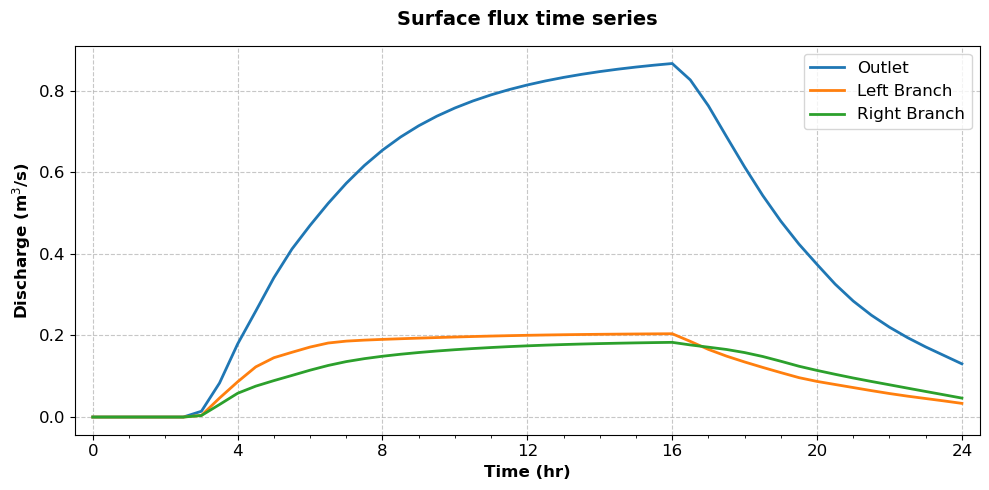

In [14]:
water_molar_density = 55500 # mol/m^3

fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.plot(observations['time [h]'], observations['surface-flux-outlet']/water_molar_density, 
        label='Outlet', linewidth=2)
ax.plot(observations['time [h]'], -observations['surface-flux-left-branch']/water_molar_density,
        label='Left Branch', linewidth=2)
ax.plot(observations['time [h]'], -observations['surface-flux-right-branch']/water_molar_density,
        label='Right Branch', linewidth=2)

# Customize axes
ax.set_xlabel('Time (hr)', fontsize=12, fontweight='bold')
ax.set_ylabel('Discharge (m$^3$/s)', fontsize=12, fontweight='bold')
ax.tick_params(axis='both', labelsize=12)
ax.grid(True, linestyle='--', alpha=0.7)
ax.xaxis.set_major_locator(MultipleLocator(4))  # Major ticks every 4 hours
ax.xaxis.set_minor_locator(MultipleLocator(1))  # Minor ticks every hour

# Add legend
ax.legend(fontsize=12, frameon=True)
ax.set_title('Surface flux time series', 
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlim([-0.5, 24.5])
plt.tight_layout()
plt.show()
